## The stochastic SIR model

The SIR model of epidemiology partitions the population into three compartments: susceptibles, S, who can catch the disease; infectives, I, who have already caught the disease and infect susceptibles; and recovered individuals, R. Since the disease is assumed not to be fatal, the sum $N=S+I+R$ remains constant. The rate at which the susceptibles get infected is 
$$
\lambda(t) = \frac{\beta I}{N}
$$
where the parameter $\beta$ is the probability of infection on contact. The infected individuals recover from the disease at a rate $\gamma$.

Based on these rates, the present example creates realisations for the stochastic trajectories for the populations $(S,I,R)$. For $100$ stochastic trajectories, the mean and variance of the observed trajectories for the number of infectives is calculated, plotted as a function of time, and compared to results from the corresponding deterministic SIR model.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### Simulation of a single stochastic trajectory

In [4]:
M = 1                  # the SIR model has no age structure
Ni = 5e4*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.5            # infection rate 
gIa   = 1/14           # recovery rate of asymptomatic infectives 
gIs   = 1/14          # recovery rate of symptomatic infectives 
alpha = 0              # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 


Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([5])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 102;  Nt=102; 

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

# simulate model 
data = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)

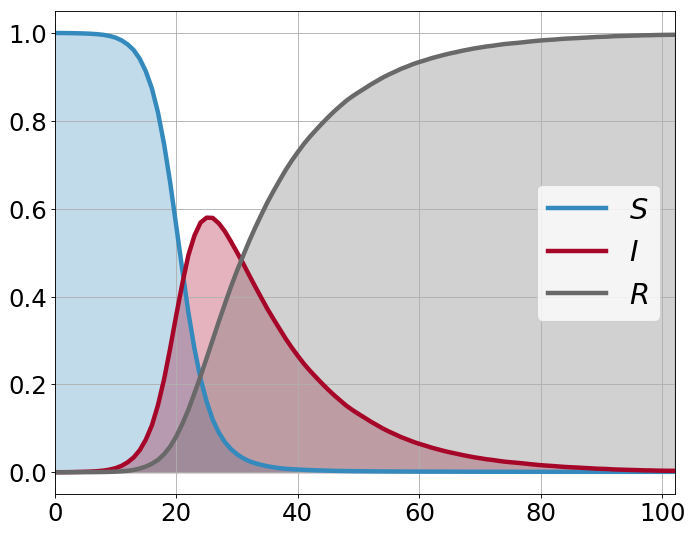

In [5]:
# plot the data and obtain the stochastic epidemic curve
S  = data['X'][:,0].flatten()
Ia = data['X'][:,1].flatten()
Is = data['X'][:,2].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=N-S-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

Note that, since here sample trajectories for the stochastic model are generated, a slightly different plot will result every time the two cells above are run. 


### Averaging over several simulations

If the simulation is run many times, mean and standard deviation of the resulting trajectories can be calculated and compared to the deterministic SIR model.

In [6]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 100
trajectories_s = np.zeros([N_runs,Nt+1,3],dtype=float)
for i in range(N_runs):
    cur_result = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt) 
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']
mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)

In [7]:
np.save('trajs.npy', trajectories_s)

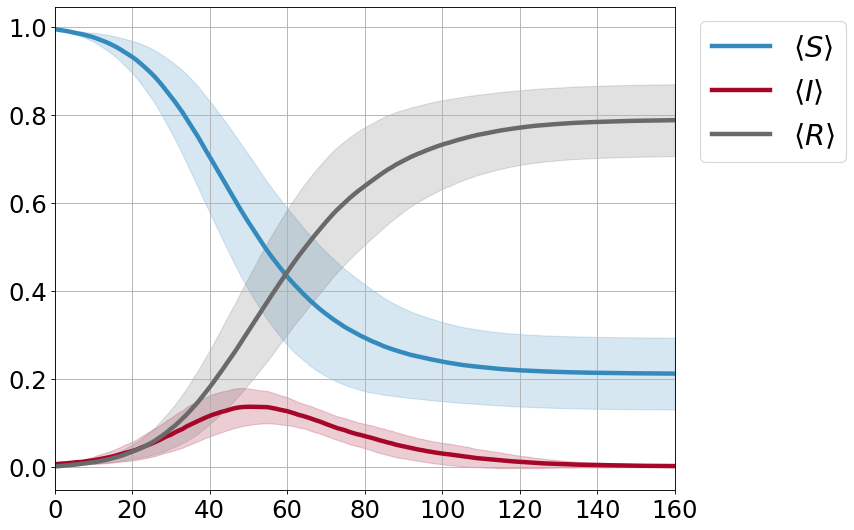

In [5]:
# plot mean and standard deviation

S_s  = mean_s[:,0].flatten()
Ia_s = mean_s[:,1].flatten()
Is_s = mean_s[:,2].flatten()
dS_s = std_s[:,0].flatten()
dIa_s = std_s[:,1].flatten()
dIs_s = std_s[:,2].flatten()
# for the recovered, we still need to calculate mean and variance
R_s_trajectories = N - trajectories_s[:,:,0] - trajectories_s[:,:,1] - trajectories_s[:,:,2]
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# stochastic
plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_s,(Is_s - dIs_s)/N,(Is_s + dIs_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, Is_s/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)


plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.

### Comparison of deterministic simulations with averages over stochastic simulations

In [6]:
# for comparison, we also evaluate the deterministic SIR model
model_d = pyross.deterministic.SIR(parameters, M, Ni)
data_d = model_d.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)

S_d  = data_d['X'][:,0].flatten()
Ia_d = data_d['X'][:,1].flatten()
Is_d = data_d['X'][:,2].flatten()
R_d = N - S_d - Ia_d - Is_d
t_d = data_d['t']

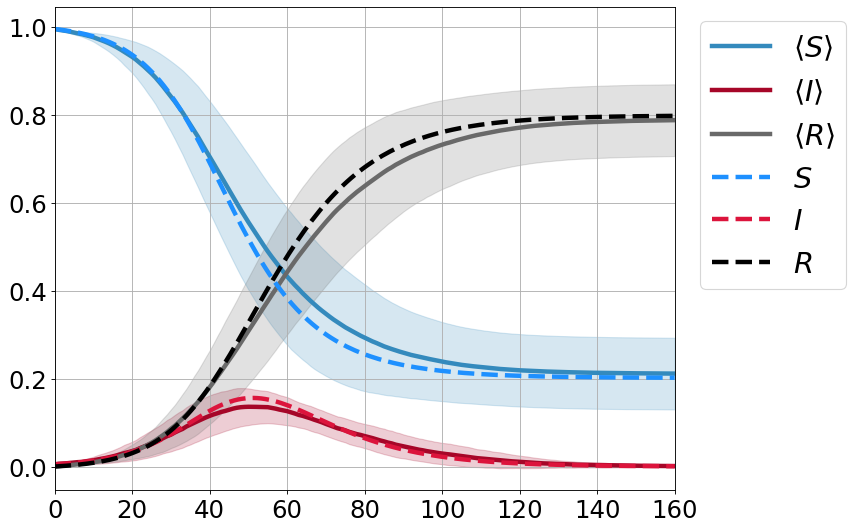

In [7]:
# plot stochastic and deterministic model

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# stochastic
plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_s,(Is_s - dIs_s)/N,(Is_s + dIs_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, Is_s/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)

# deterministic
plt.plot(t_d, S_d/N, '--', color="dodgerblue", label='$S$', lw=4)
plt.plot(t_d, Is_d/N, '--', color='crimson', label='$I$', lw=4)
plt.plot(t_d, R_d/N, '--', color="black", label='$R$', lw=4)

plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

The dashed colored lines denote the results from the deterministic SIR model.

For the small population numbers considered here, deviations between deterministic and stochastic simulations can be observed. Running the whole notebook again with a larger total population of, for example, $N=10000$ and an initial infective population of $I_{0} = 100$, one will observe very good agreement between stochastic and deterministic model. 